### We can construct a mosaic of nearby tiles using this method: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/discussion/36738

# Construct image tile mosaic
---

uint8
(256, 256, 3)


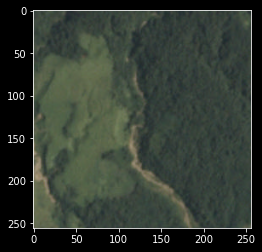

In [59]:
# load and display an image with Matplotlib
import matplotlib
from matplotlib import pyplot as plt

# load image as pixel array
image = matplotlib.image.imread('data/train-jpg/train_1.jpg')

# drop alpha channel
image = image[:, :, :3]

# summarize shape of the pixel array
print(image.dtype)
print(image.shape)

# display the array of pixels as an image
plt.imsave('left_strip.jpg', left_strip)
plt.imsave('right_strip.jpg', right_strip)
plt.imsave('top_strip.jpg', top_strip)
plt.imsave('bottom_strip.jpg', bottom_strip)
left_strip = image[:, 0, :]
right_strip = image[:, 255, :]
top_strip = image[0, :, :]
bottom_strip = image[255, :, :]

plt.imshow(image)
plt.show()

# 1) Get vectors of all edges of images. So 4 vectors of size 3*256 for each image.

# 2) For each image find difference between top vector and bottom vector of all other images. Take the minimum. It will be the TOP neighbour. Do the same for BOTTOM, LEFT and RIGHT.

# 3) Using the same algorithm get neighbours for all TIFF images.

# 4) Remove neighbours which is different for JPG and TIFF images.

# 5) Use diagonals to additional improvements. For example check that diagonal element have same neighbours as central one without conflicts and so on…

# 6) Use CNN averaged predictions for 4 or 8 neighbours as features for central element

# Preprocess data
---

In [32]:
# extract labels from training data
import pandas as pd

train_data = pd.read_csv('data/train_v2.csv/train_v2.csv')
print(train_data['tags'].values)

unique_labels = []
for line in train_data['tags'].values:
    for label in line.split():
        if label not in unique_labels:
            unique_labels.append(label)
            print(label)

print(len(unique_labels))

['haze primary' 'agriculture clear primary water' 'clear primary' ...
 'agriculture clear primary' 'agriculture clear primary road'
 'agriculture cultivation partly_cloudy primary']
haze
primary
agriculture
clear
water
habitation
road
cultivation
slash_burn
cloudy
partly_cloudy
conventional_mine
bare_ground
artisinal_mine
blooming
selective_logging
blow_down
17


# Construct model
---

# Train model
---

# View results
---